#### Notebook `Data Preprocessing`

#### Group:
- `Miguel Matos - 20221925`
- `André Nicolau - 20221861`
- `André Ferreira - 20250398`

---

#### <font> Table of Contents </font> <a class="anchor" id='toc'></a> 
1. [Imports](#Imports)
2. [Data Preprocessing](#data-preprocessing)

- 2.1. [Missing Values](#missing-values)
- 2.2. [Outliers](#outliers)
- 2.3. [Encoding Categorical Variables](#encoding-categorical-variables)
- 2.4. [Feature Engeneering](#feature-engeneering)


----

# Imports
[Back to TOC](#toc)

In [32]:
from functions import *

In [33]:
data = pd.read_csv("/Users/miguelmatos/Documents/GitHub/Machine_Learning_project/ML_Project_Group42/data/data_cleaned.csv", index_col= "carID")
pd.set_option("display.max_columns", None)

# Data Preprocessing

Now, we want to split the data, and use "Brand" to stratify the data. For that, we need to make sure there are no missing values on "Brand".

In [34]:
data.isna().sum()

Brand              236
model             1517
car_age           1491
price                0
transmission      1522
mileage           1832
fuelType          1515
tax               8282
mpg               7962
engineSize        1780
paintQuality%     1891
previousOwners    1921
dtype: int64

As there are only 236 rows in "Brand" with missing values, and we want to use "Brand" to stratify the data, we'll delete these rows.

In [35]:
data.dropna(subset=["Brand"], inplace=True)

Let's splitt the data now.

In [36]:
cars_data = data.drop("price", axis = 1)
target_data = data["price"]

In the following cell, we'll split the data into 70% for train and 30% for test, as we have a big amount of data (around 75k rows).


In [37]:
X_train, X_val, y_train, y_val = train_test_split(cars_data, target_data, 
                                                    test_size= 0.3, 
                                                    random_state= 7, # 7 because of Ronaldo :)
                                                    shuffle= True, # True, because the data is ordered by brands
                                                    stratify = cars_data["Brand"])

In [38]:
print(f"The length of the training data is {len(X_train)}.")
print(f"The length of the validation data is {len(X_val)}.")

The length of the training data is 53015.
The length of the validation data is 22722.


## Missing Values
[Back to TOC](#toc)

### Impute Numerical

In [39]:
metric_features = ["car_age", "mileage", "engineSize", "paintQuality%", "previousOwners", "tax", "mpg"]

In [40]:
#Here we are scaling for each brand 

imputer = KNNImputer(n_neighbors=5, weights="uniform")


imputed_list = [] #to store the imputed results


for brand, df_brand in X_train.groupby("Brand"):

    df_temporary = df_brand.copy() #so that we don't modify the original

    scaler = StandardScaler() #Define the Scaler

    scaled_data = scaler.fit_transform(df_temporary[metric_features]) #Scale an transform the data

    imputed_scaled = imputer.fit_transform(scaled_data)  #Apply KNN imputer on scaled data

    df_temporary[metric_features] = scaler.inverse_transform(imputed_scaled) #Reverse scaling

    imputed_list.append(df_temporary) # Adding each dataframe to our imputed_list


X_train = pd.concat(imputed_list, axis=0)   # Combine all brands again
X_train = X_train.loc[X_train.index]  # restore original order

In [41]:
X_train.isna().sum()

Brand                0
model             1069
car_age              0
transmission      1056
mileage              0
fuelType          1086
tax                  0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
dtype: int64

### Impute Categorical

In [42]:
non_metric_features = ["model", "transmission", "fuelType"]

In [43]:
for col in non_metric_features:
    mode_value = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_value)

In [44]:
X_train.isna().sum()

Brand             0
model             0
car_age           0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
dtype: int64

## Outliers
[Back to TOC](#toc)

Firstly, let's visualize the data distribution of our trainning data.

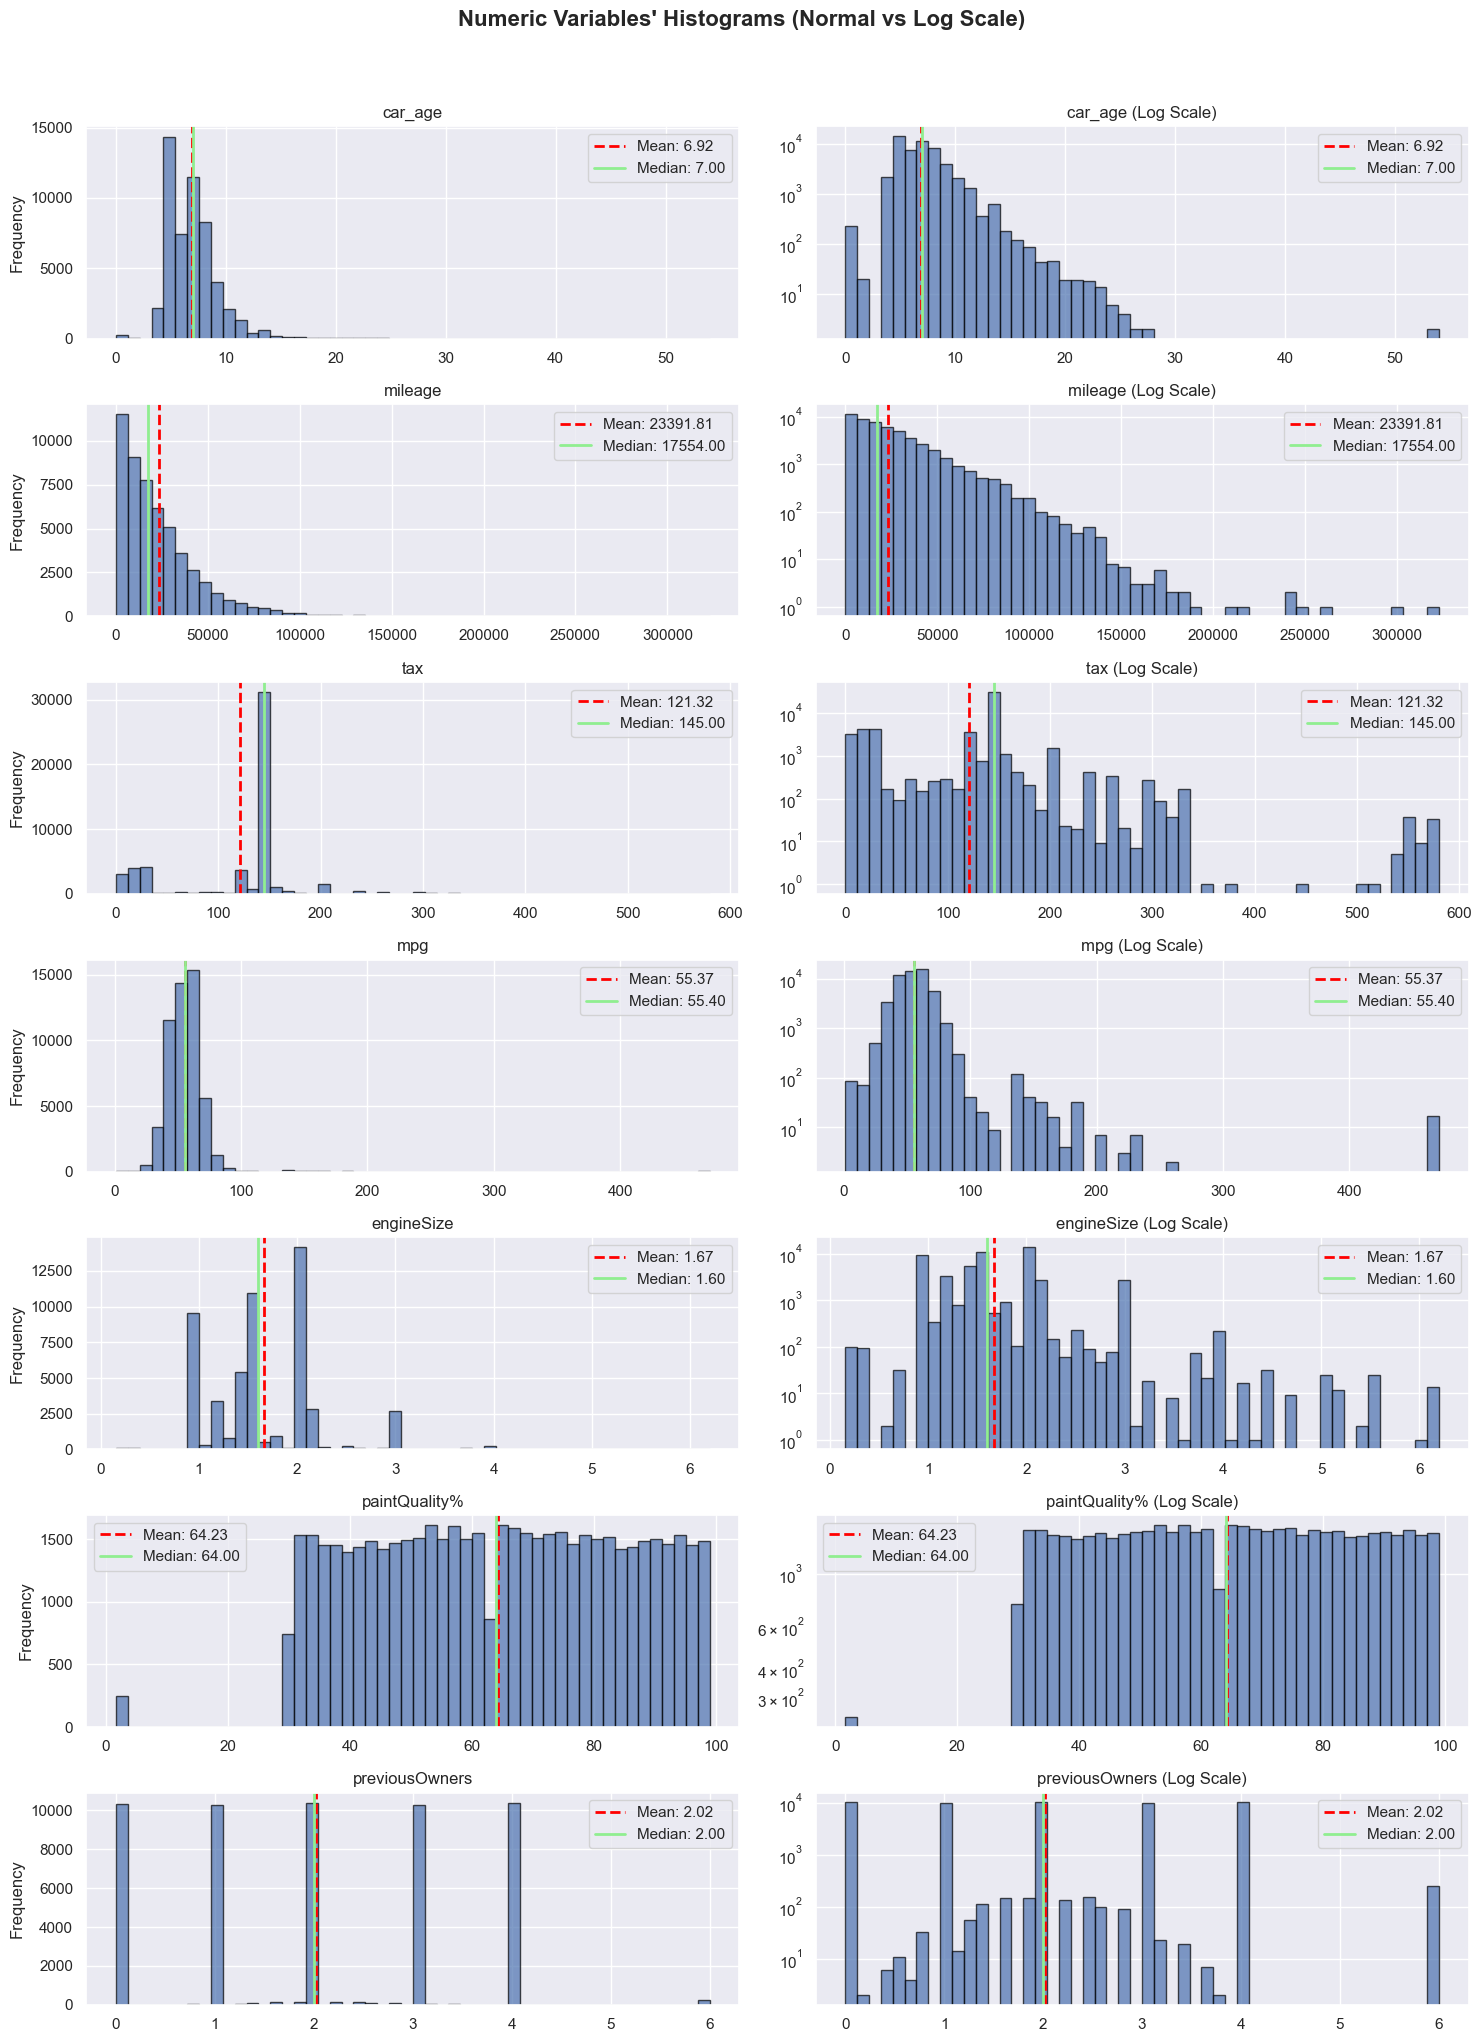

In [45]:
# Plot ALL Numeric Variables' Histograms in one figure
sns.set(style= "darkgrid")

metric_features = X_train.select_dtypes(include=np.number)

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(7, 2, figsize=(15, 20))

# Loop through each feature
for i, feat in enumerate(metric_features):

    # Calculate mean and median
    mean_val = X_train[feat].mean()
    median_val = X_train[feat].median()
    
    # Left plot: normal histogram
    axes[i, 0].hist(X_train[feat], bins = 50, edgecolor= "black", alpha = 0.7)
    axes[i, 0].set_title(f"{feat}")
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i, 0].axvline(median_val, color='lightgreen', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i, 0].legend()

    # Right plot: log-scale histogram
    axes[i, 1].hist(X_train[feat], bins= 50, log = True, edgecolor= "black", alpha = 0.7)
    axes[i, 1].set_title(f"{feat} (Log Scale)")
    axes[i, 1].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i, 1].axvline(median_val, color='lightgreen', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i, 1].legend()

# Adjust layout and add overall title
fig.suptitle("Numeric Variables' Histograms (Normal vs Log Scale)", fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

In [46]:
X_train.loc[X_train["car_age"] > 30]

,Brand,model,car_age,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,
35769,Mercedes,M class,54.0,Automatic,14000.0,Diesel,305.0,39.2,1.92,44.0,3.0
62732,Opel,Zafira,54.0,Manual,37357.0,Petrol,200.0,42.2,1.52,60.0,2.0


As the number of cars with age superior to 30 is only 2, and both have 54 years, we will cap them to the superior limit before these two cases.

In [47]:
X_train.loc[X_train["car_age"] > 30, "car_age"] = X_train.loc[X_train["car_age"] < 30, "car_age"].max()

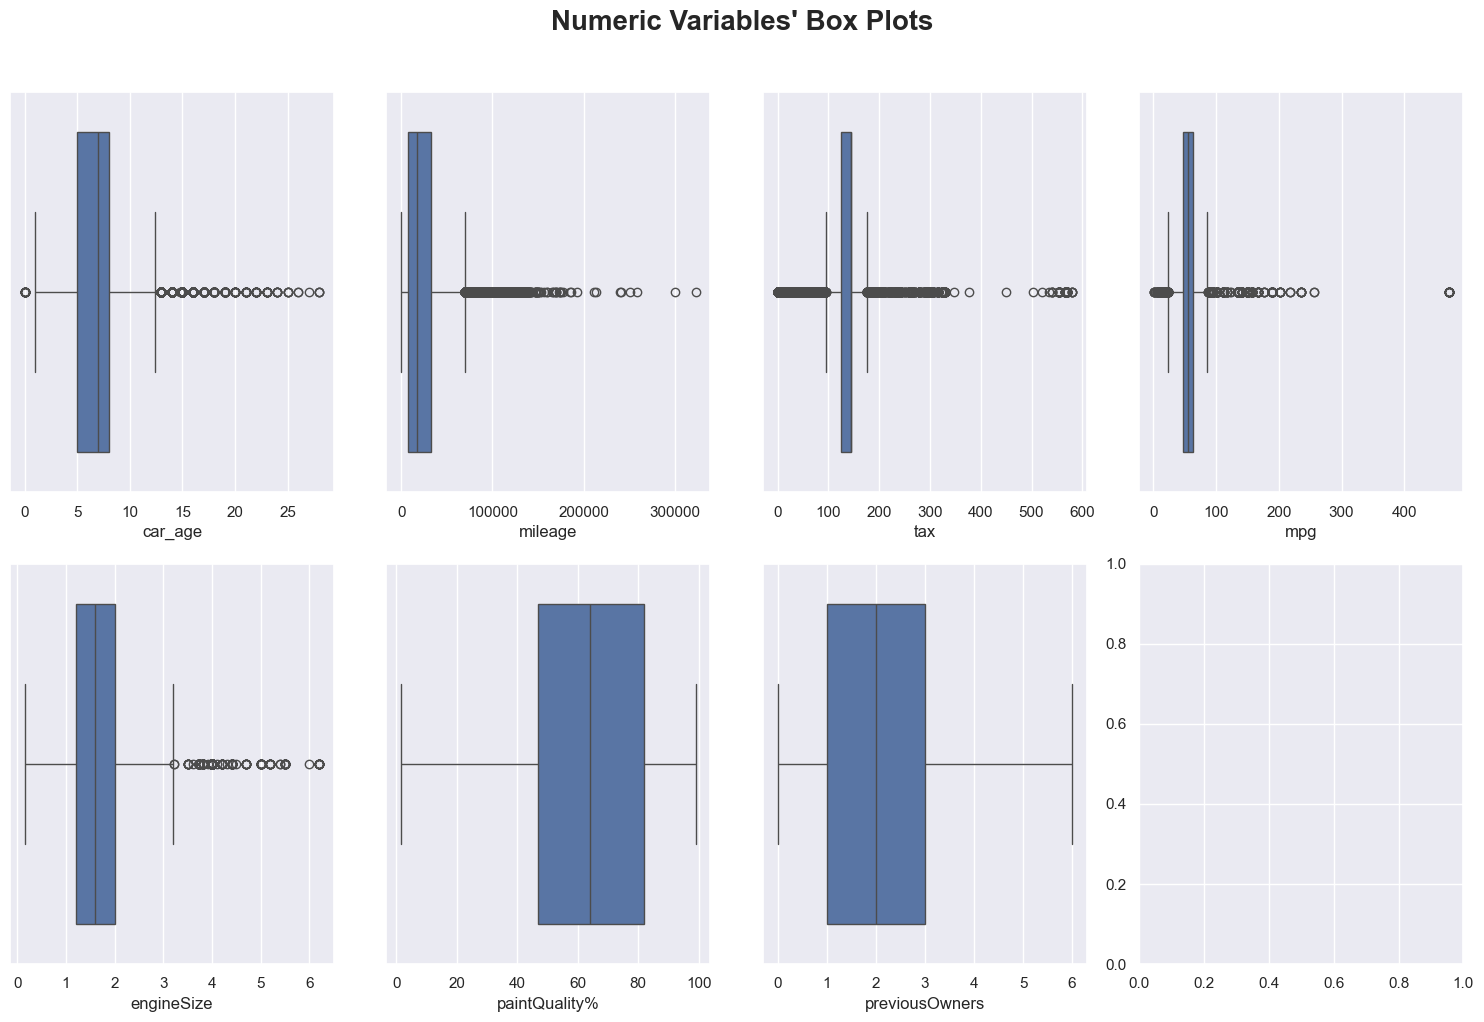

In [48]:
metric_features = X_train.select_dtypes(include=np.number)
boxplotter(X_train, metric_features, n_rows=2, n_cols=4)

With the visualization of both histograms and boxplots, we conclude that the variables where outliers will be removed are:
- "tax" and "mpg": All outliers will be removed

- The variable "engineSize" will not have the outliers removed, as the high values of engine Size are related to the most expansive brands, and doing so, would mean cutting out mostly the top 3 most expansive brands: "Audi", "BMW", and "Mercedes".

As the refered distributions are really skewed and the dataset is large, we'll use the IQR(Interquartil range) method to cap the outliers.

In [49]:
outliers_col = ["car_age", "mileage", "tax", "mpg"]

for col in outliers_col:

    if col == "car_age" or col == "mileage":
        q_1 = X_train[col].quantile(0.25)
        q_3 = X_train[col].quantile(0.75)
        IQR = q_3 - q_1
        X_train[col] = np.clip(X_train[col], q_1 - 3 * IQR , q_3 + 3 * IQR) # Only severe outliers capped
        
    else:
        q_1 = X_train[col].quantile(0.25)
        q_3 = X_train[col].quantile(0.75)
        IQR = q_3 - q_1
        X_train[col] = np.clip(X_train[col], q_1 - 1.5 * IQR , q_3 + 1.5 * IQR)

Let's plot the variables distributions again.

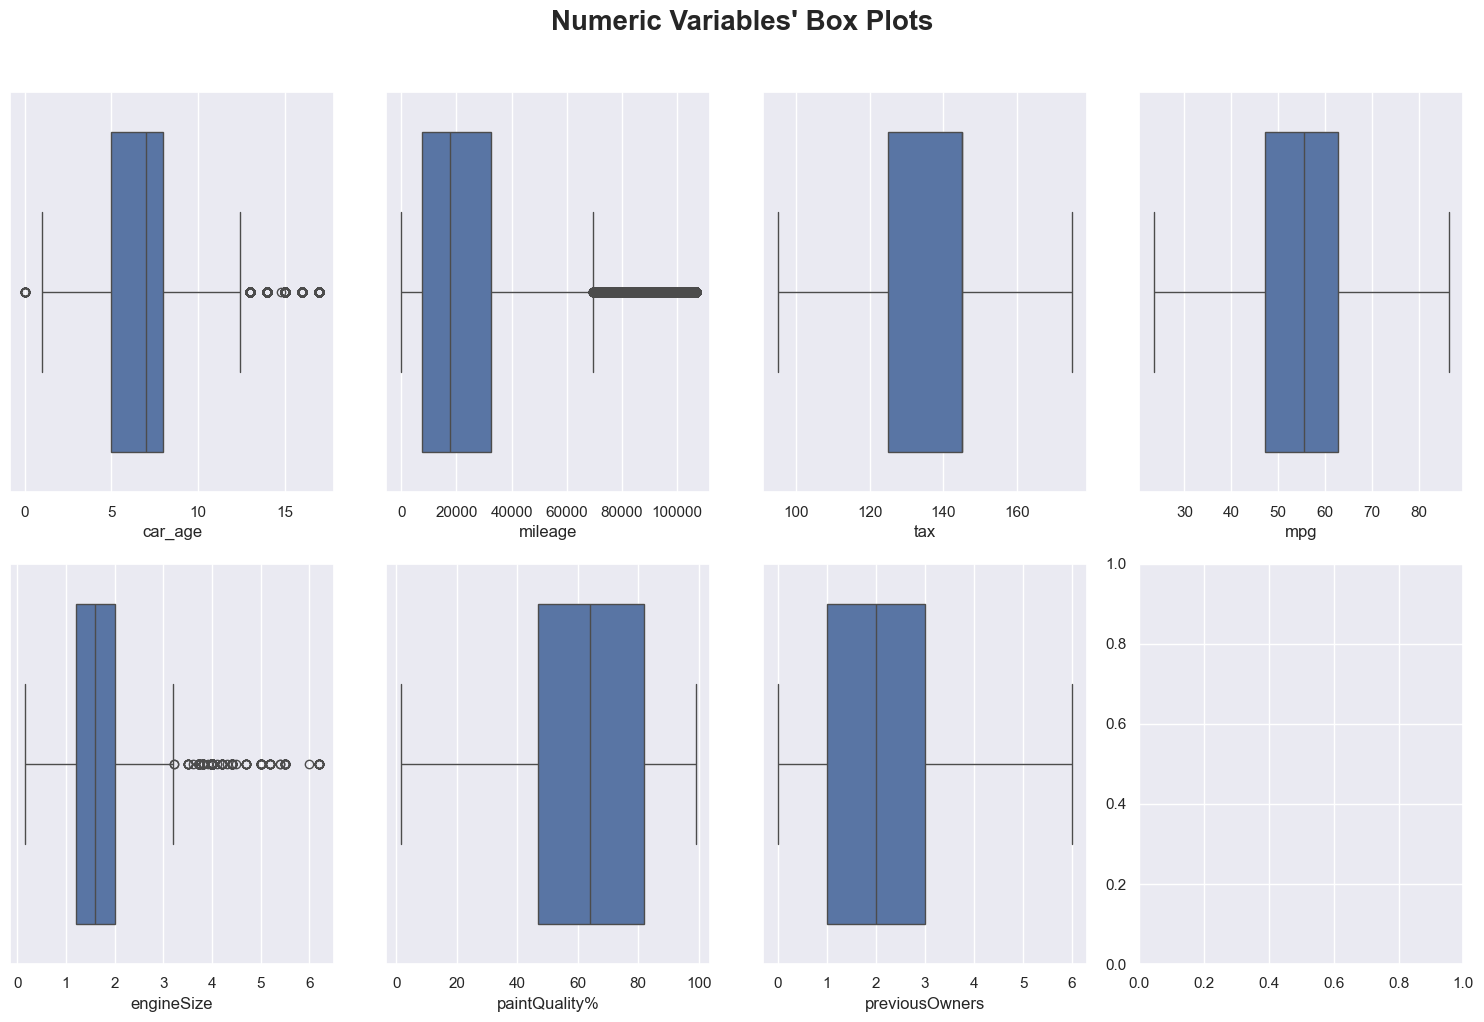

In [50]:
boxplotter(X_train, metric_features, n_rows=2, n_cols=4)

Now let's take a look to possible multidimensional outliers.

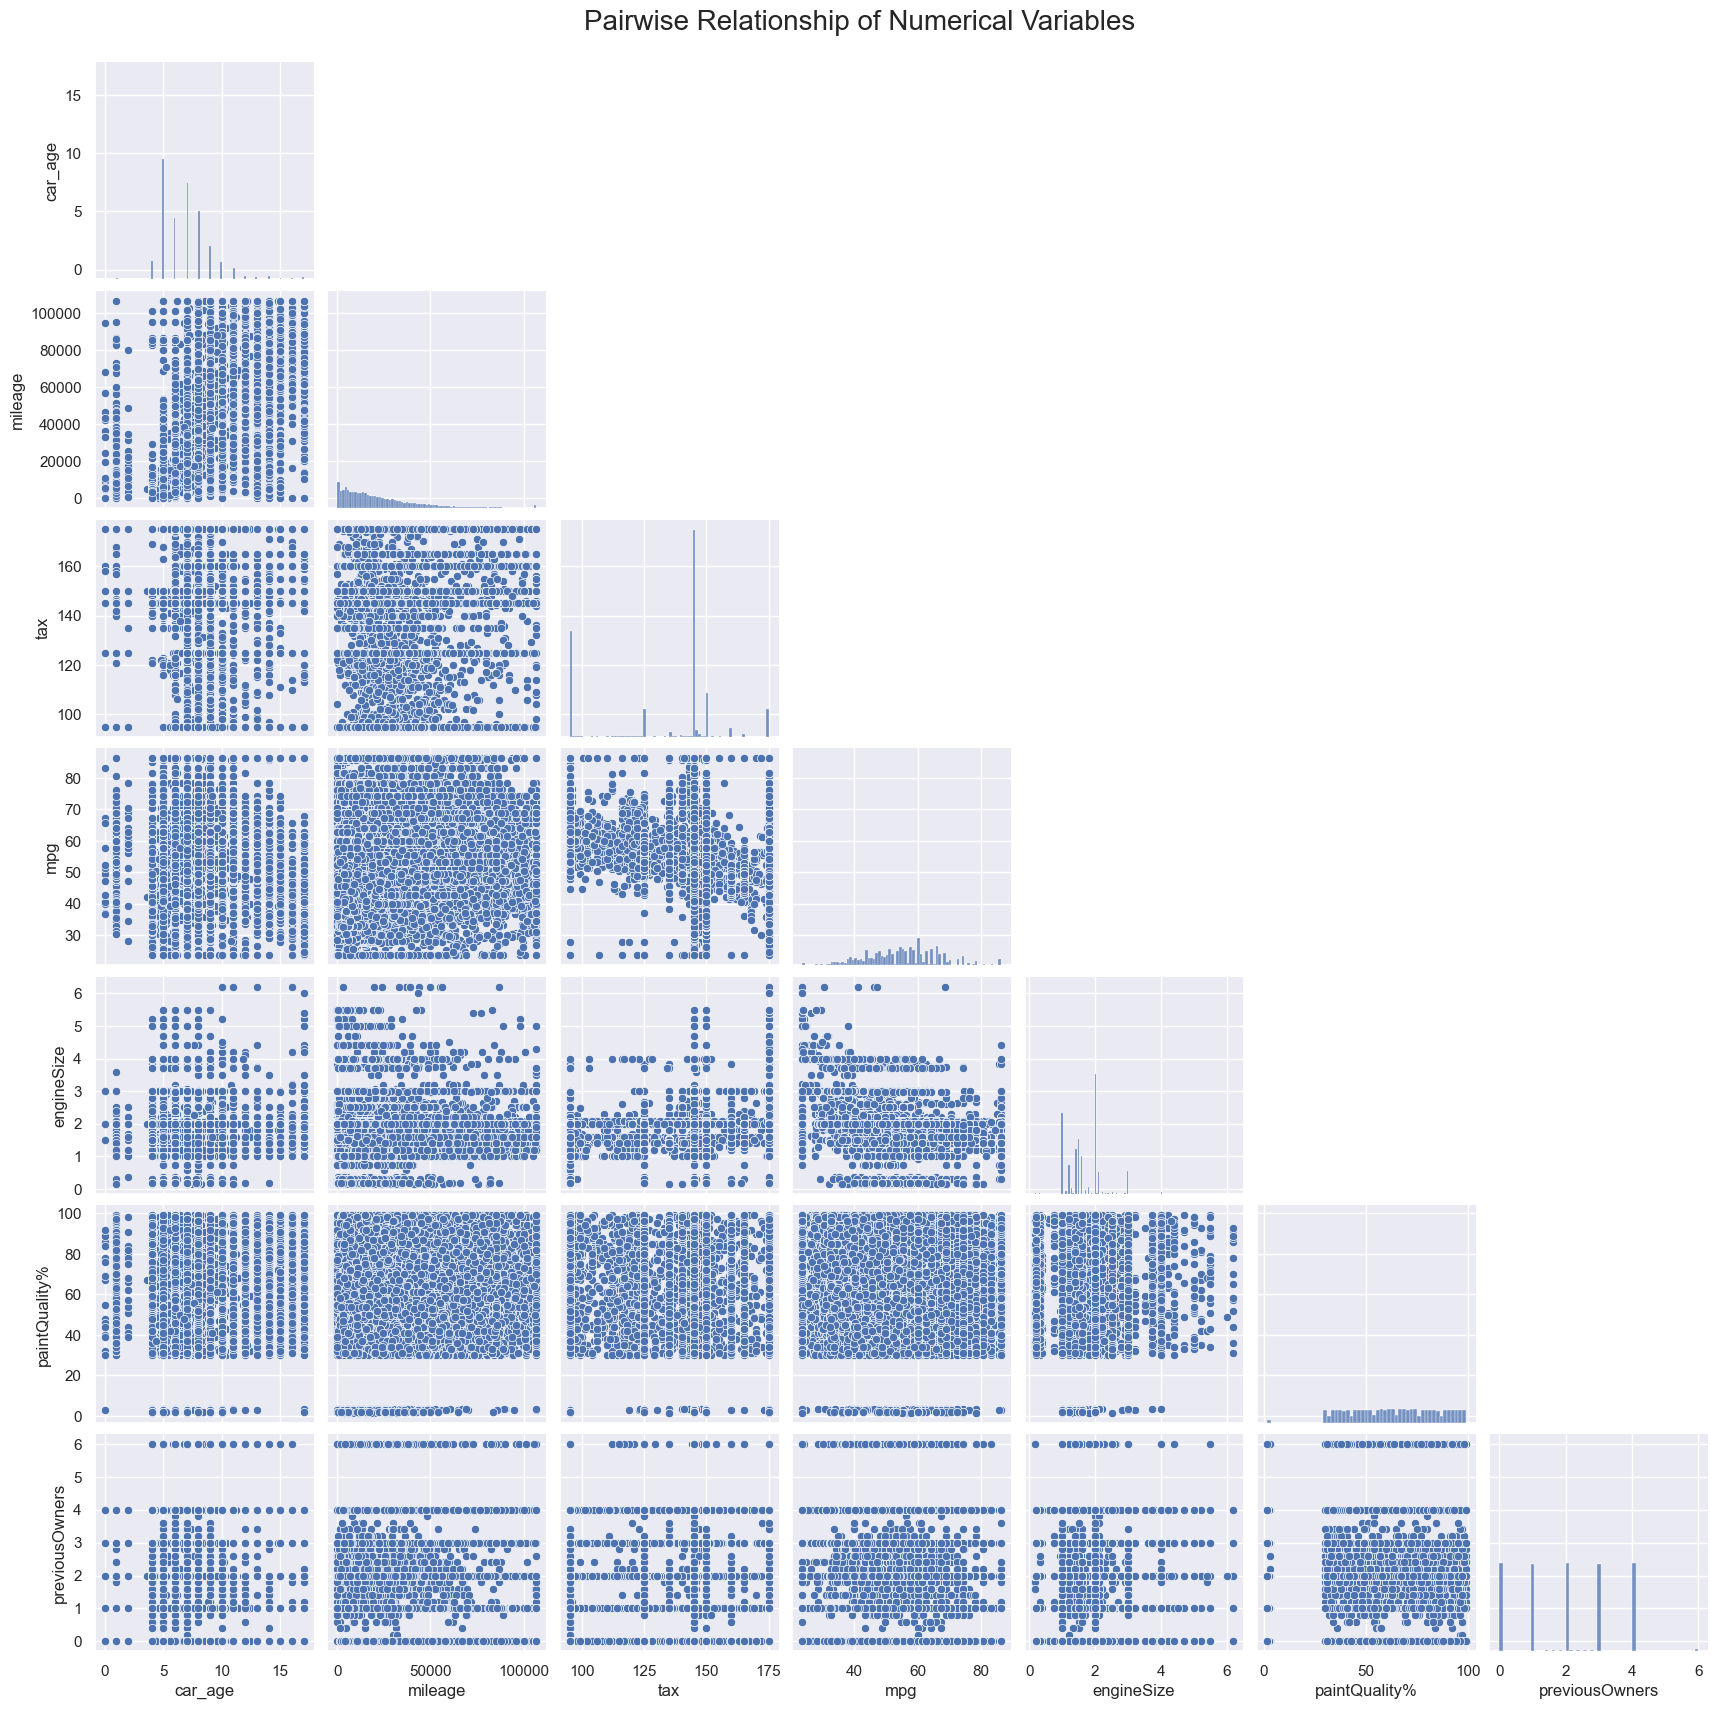

In [51]:
sns.set()

metric_features = X_train.select_dtypes(include=np.number)
g = sns.pairplot(metric_features)

# Mask the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)
plt.show()


Doesn't seem to have any significant multidimensional outliers.

## Encoding Categorical Variables
[Back to TOC](#toc)

Let's start by transforming the columns "Brand" and "model.

In [52]:
encoder = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False)
encoded = encoder.fit_transform(X_train[["Brand"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df], axis=1)

In [53]:
le = LabelEncoder()
for brand in X_train["Brand"].unique().tolist():
    labels = le.fit_transform(X_train.loc[X_train["Brand"] == brand, "model"])
    X_train.loc[X_train[brand] == 1, brand] = labels

In [54]:
X_train.drop(columns= ["Brand", "model"], inplace=True)

Now, we'll move on to encode "fuelType".

In [55]:
X_train["fuelType"].value_counts()

fuelType
Petrol    29862
Diesel    21494
Hybrid     1539
Other       120
Name: count, dtype: int64

In [56]:
encoder = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False, drop = ["Other"])
encoded = encoder.fit_transform(X_train[["fuelType"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df], axis=1)
X_train.drop("fuelType", axis= 1, inplace= True)

Finally, let's encode the column "transmission".

In [57]:
X_train["transmission"].value_counts()

transmission
Manual       30142
Semi-Auto    11700
Automatic    10660
Unknown        510
Other            3
Name: count, dtype: int64

--- 

ESTAMOS A REMOVER OS "OTHER" TEMPORÁRIAMENTE !!!!

--- 

In [58]:
indexes = X_train[X_train["transmission"] == "Other"].index.to_list()

X_train.drop(index=indexes, inplace=True)
y_train.drop(index=indexes, inplace=True)

--- 

ESTAMOS A REMOVER OS "OTHER" TEMPORÁRIAMENTE !!!!

--- 

In [59]:
#X_train = X_train.loc[~X_train["transmission"].isin(["Other"])] # removing the 3 rows with "Other"
encoder = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False, drop = ["Unknown"])
encoded = encoder.fit_transform(X_train[["transmission"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df], axis=1)
X_train.drop("transmission", axis= 1, inplace= True)

In [60]:
X_train

,car_age,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Audi,BMW,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,VW,Diesel,Hybrid,Petrol,Automatic,Manual,Semi-Auto
carID,,,,,,,,,,,,,,,,,,,,,,
1696,8.0,38578.0,99.0,49.6,1.400000,33.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4757,5.0,100.0,145.0,47.1,2.000000,38.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2943,13.0,69145.0,125.0,53.3,3.739235,76.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4670,7.8,43014.0,125.0,57.6,2.000000,41.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2761,9.0,51546.4,175.0,41.5,3.000000,59.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66597,5.0,53.0,150.0,36.2,1.500000,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,1.0,0.0,1.0,0.0
67737,4.0,3500.0,145.0,49.6,1.000000,85.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0
74109,7.0,13752.0,150.0,42.8,3.000000,67.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,0.0,0.0,1.0,0.0,0.0


## Feature Engeneering
[Back to TOC](#toc)

In [61]:
X_train

,car_age,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Audi,BMW,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,VW,Diesel,Hybrid,Petrol,Automatic,Manual,Semi-Auto
carID,,,,,,,,,,,,,,,,,,,,,,
1696,8.0,38578.0,99.0,49.6,1.400000,33.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4757,5.0,100.0,145.0,47.1,2.000000,38.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2943,13.0,69145.0,125.0,53.3,3.739235,76.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4670,7.8,43014.0,125.0,57.6,2.000000,41.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2761,9.0,51546.4,175.0,41.5,3.000000,59.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66597,5.0,53.0,150.0,36.2,1.500000,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,1.0,0.0,1.0,0.0
67737,4.0,3500.0,145.0,49.6,1.000000,85.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0
74109,7.0,13752.0,150.0,42.8,3.000000,67.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,0.0,0.0,1.0,0.0,0.0


## Data Scaling
[Back to TOC](#toc)

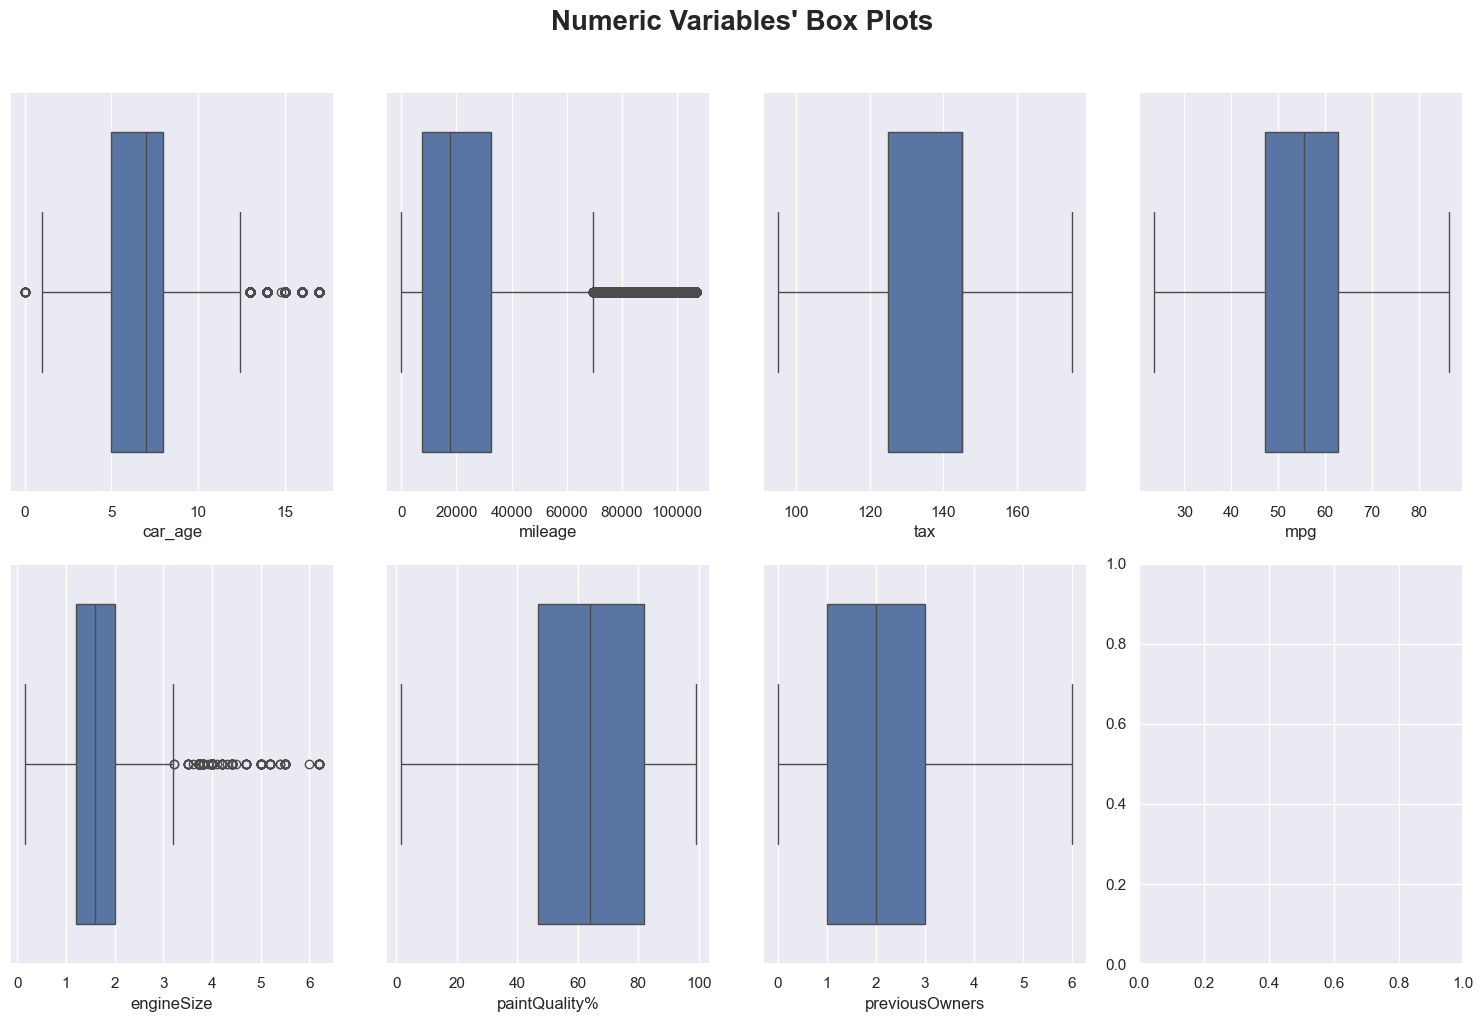

In [62]:
boxplotter(X_train, metric_features = X_train[["car_age", "mileage", "tax", "mpg", "engineSize", "paintQuality%", "previousOwners"]], n_rows=2, n_cols=4)

As there are a three variables with skewed distributions, which contain outliers, but these are not removed as they represent important insights, the best scaler to use is the Robust scaler, as this scaler leads better with outliers.

In [64]:
scaler = RobustScaler()

#fit to training data
scaler.fit(X_train)

#transform the data
X_train_scaled = scaler.transform(X_train)

# Convert the array to a pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns).set_index(X_train.index)
X_train_scaled

NameError: name 'RobustScaler' is not defined